#  <center> Speech Emotion Recognition <center>

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from scipy import signal
from IPython.display import Audio

In [2]:
pip install --upgrade librosa

In [3]:
pip install np_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 679.6 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56439 sha256=a251c80b918ae256bc2df17f0fcf73698d2d9ccdf2bfad6737cf1607d49bf5b5
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


In [4]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
import np_utils
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Data Preparation



In [5]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio
!unzip ravdess-emotional-speech-audio.zip -d ravdess

!kaggle datasets download -d ejlok1/cremad
!unzip cremad.zip -d cremad

!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess
!unzip toronto-emotional-speech-set-tess.zip -d Tess

!kaggle datasets download -d ejlok1/surrey-audiovisual-expressed-emotion-savee
!unzip surrey-audiovisual-expressed-emotion-savee.zip -d savee

Streaming output truncated to the last 5000 lines.
  inflating: Tess/TESS Toronto emotional speech set data/OAF_happy/OAF_lid_happy.wav  
  inflating: Tess/TESS Toronto emotional speech set data/OAF_happy/OAF_life_happy.wav  
  inflating: Tess/TESS Toronto emotional speech set data/OAF_happy/OAF_limb_happy.wav  
  inflating: Tess/TESS Toronto emotional speech set data/OAF_happy/OAF_live_happy.wav  
  inflating: Tess/TESS Toronto emotional speech set data/OAF_happy/OAF_loaf_happy.wav  
  inflating: Tess/TESS Toronto emotional speech set data/OAF_happy/OAF_long_happy.wav  
  inflating: Tess/TESS Toronto emotional speech set data/OAF_happy/OAF_lore_happy.wav  
  inflating: Tess/TESS Toronto emotional speech set data/OAF_happy/OAF_lose_happy.wav  
  inflating: Tess/TESS Toronto emotional speech set data/OAF_happy/OAF_lot_happy.wav  
  inflating: Tess/TESS Toronto emotional speech set data/OAF_happy/OAF_love_happy.wav  
  inflating: Tess/TESS Toronto emotional speech set data/OAF_happy/OAF_

In [6]:
# Paths for data.
Ravdess = "/content/ravdess/audio_speech_actors_01-24/"
Crema = "/content/cremad/AudioWAV/"
Tess = "/content/Tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/content/savee/ALL/"

##  <center> 1. Ravdess Dataframe <center>


In [7]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Emotions                                               Path
0       sad  /content/ravdess/audio_speech_actors_01-24/Act...
1     happy  /content/ravdess/audio_speech_actors_01-24/Act...
2       sad  /content/ravdess/audio_speech_actors_01-24/Act...
3      calm  /content/ravdess/audio_speech_actors_01-24/Act...
4  surprise  /content/ravdess/audio_speech_actors_01-24/Act...

## <center>2. Crema DataFrame</center>

In [8]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Emotions                                          Path
0  neutral  /content/cremad/AudioWAV/1004_IWL_NEU_XX.wav
1      sad  /content/cremad/AudioWAV/1077_IEO_SAD_HI.wav
2    angry  /content/cremad/AudioWAV/1047_ITH_ANG_XX.wav
3      sad  /content/cremad/AudioWAV/1066_ITS_SAD_XX.wav
4      sad  /content/cremad/AudioWAV/1062_IOM_SAD_XX.wav

##  <center> 3. TESS dataset <center>

In [9]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

Emotions                                               Path
0    happy  /content/Tess/tess toronto emotional speech se...
1    happy  /content/Tess/tess toronto emotional speech se...
2    happy  /content/Tess/tess toronto emotional speech se...
3    happy  /content/Tess/tess toronto emotional speech se...
4    happy  /content/Tess/tess toronto emotional speech se...

##  <center> 4. SAVEE dataset <center>


In [10]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

Emotions                           Path
0     fear  /content/savee/ALL/DC_f10.wav
1    angry  /content/savee/ALL/JE_a15.wav
2    angry  /content/savee/ALL/DC_a13.wav
3  disgust  /content/savee/ALL/JE_d06.wav
4  neutral  /content/savee/ALL/JK_n11.wav

In [11]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0       sad  /content/ravdess/audio_speech_actors_01-24/Act...
1     happy  /content/ravdess/audio_speech_actors_01-24/Act...
2       sad  /content/ravdess/audio_speech_actors_01-24/Act...
3      calm  /content/ravdess/audio_speech_actors_01-24/Act...
4  surprise  /content/ravdess/audio_speech_actors_01-24/Act...

## Data Visualisation and Exploration

In [12]:
data_path.Emotions.value_counts()

sad         1923
happy       1923
disgust     1923
angry       1923
fear        1923
neutral     1703
surprise     652
calm         192
Name: Emotions, dtype: int64

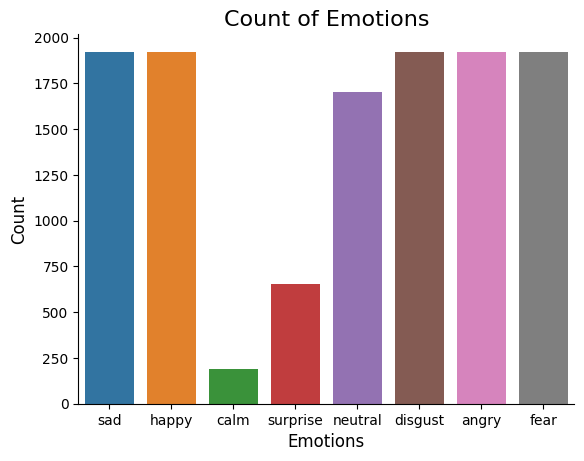

In [13]:
plt.title('Count of Emotions', size=16)
sns.countplot(data = data_path, x='Emotions')
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [14]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

In [15]:
def create_spectrogram(data, sampling_rate, emotion):
    f, t, Sxx = signal.spectrogram(data, sampling_rate)
    plt.figure(figsize=(10, 6))
    sns.set()  # Using seaborn style
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud', cmap='viridis')
    plt.colorbar(label='Intensity (dB)')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    plt.title('Spectrogram for ' + emotion + ' emotion')
    plt.show()

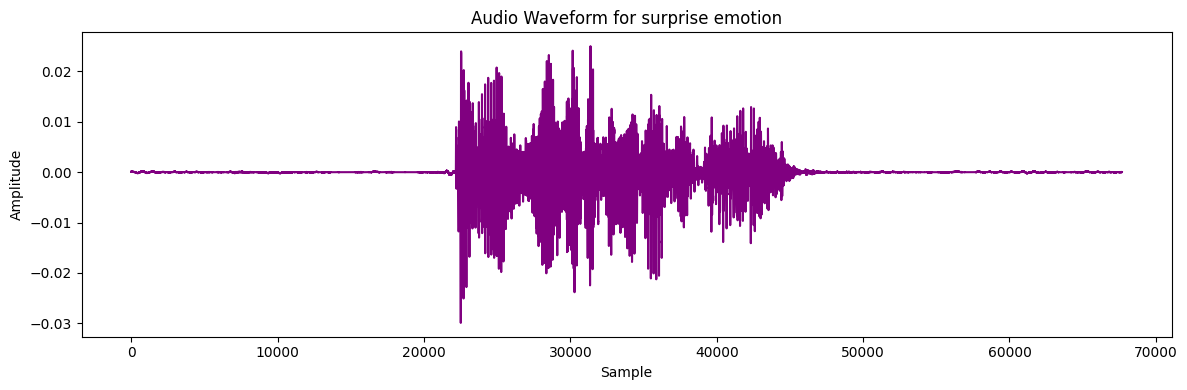

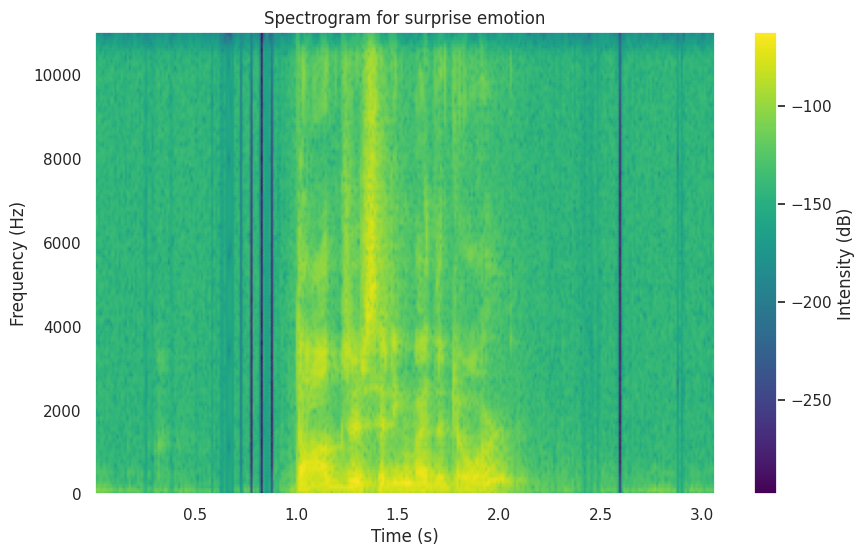

In [16]:
emotion = 'surprise'
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]
data, sampling_rate = librosa.load(path)

plt.figure(figsize=(12, 4))
plt.plot(data, color='purple')  # Adjust color
plt.title('Audio Waveform for ' + emotion + ' emotion')  # Add title
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.tight_layout()  # Ensures all elements fit nicely
plt.show()

create_spectrogram(data, sampling_rate, emotion)
Audio(path)

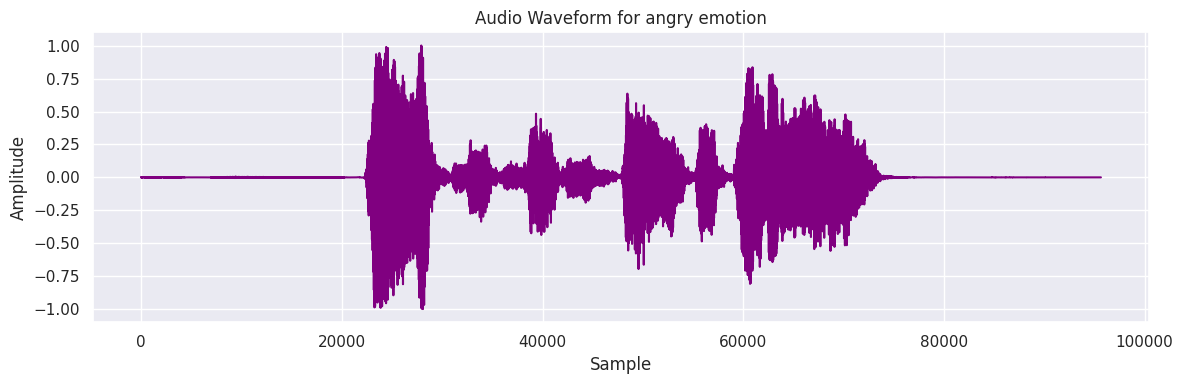

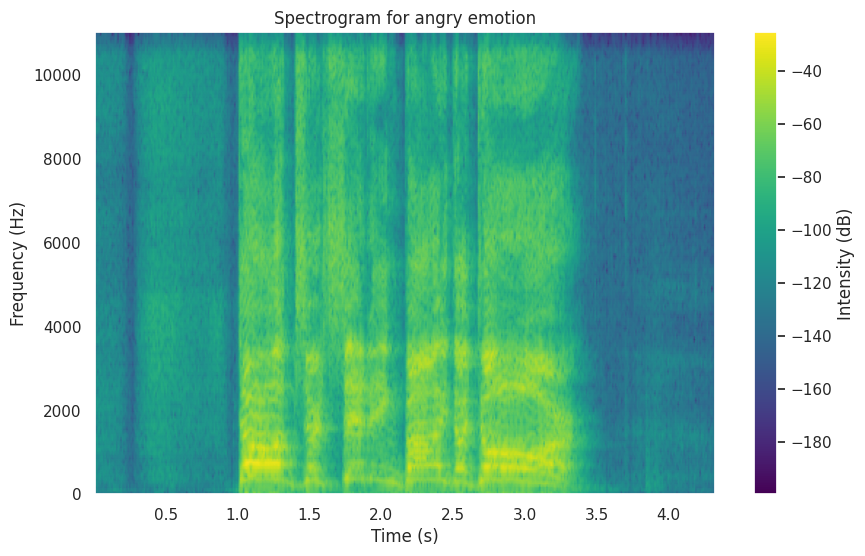

In [17]:
emotion = 'angry'
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]
data, sampling_rate = librosa.load(path)

plt.figure(figsize=(12, 4))
plt.plot(data, color='purple')  # Adjust color
plt.title('Audio Waveform for ' + emotion + ' emotion')  # Add title
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.tight_layout()  # Ensures all elements fit nicely
plt.show()

create_spectrogram(data, sampling_rate, emotion)
Audio(path)


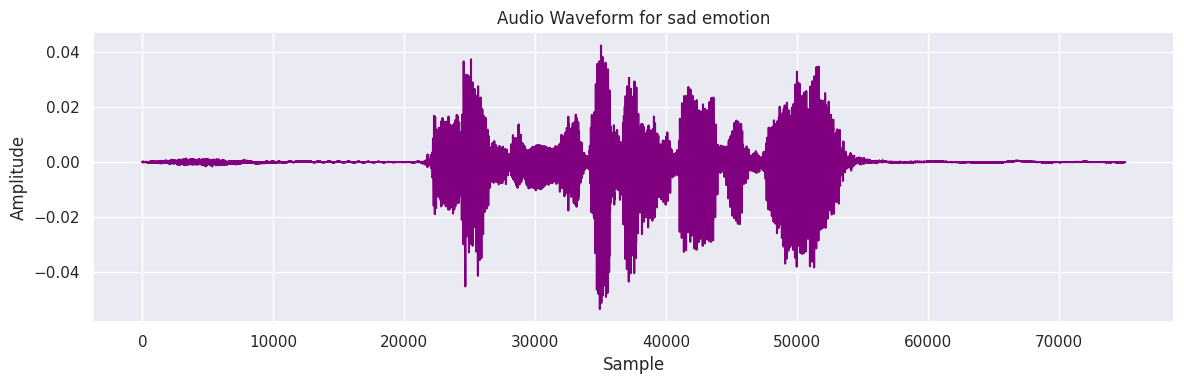

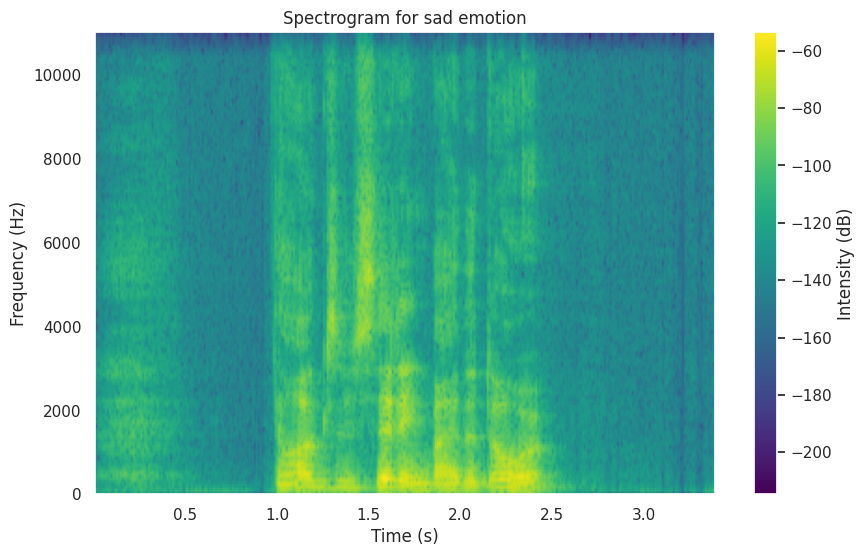

In [18]:
emotion = 'sad'
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]
data, sampling_rate = librosa.load(path)

plt.figure(figsize=(12, 4))
plt.plot(data, color='purple')  # Adjust color
plt.title('Audio Waveform for ' + emotion + ' emotion')  # Add title
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.tight_layout()  # Ensures all elements fit nicely
plt.show()

create_spectrogram(data, sampling_rate, emotion)
Audio(path)

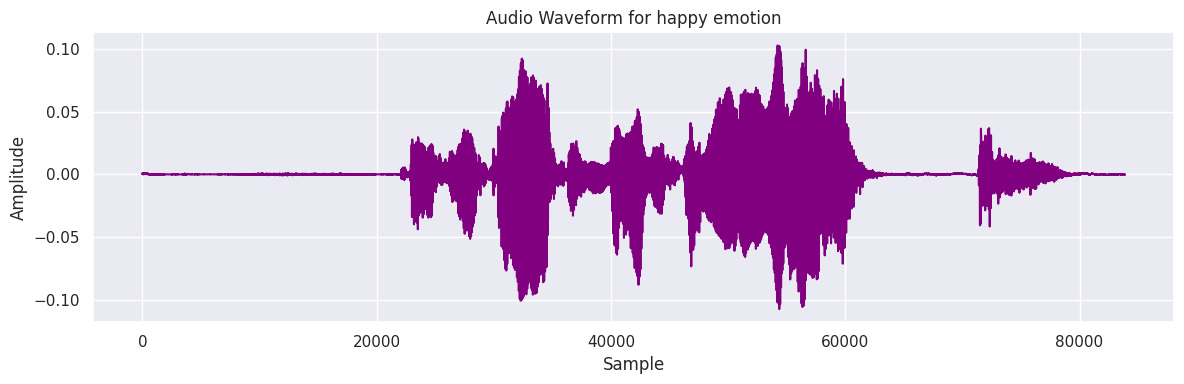

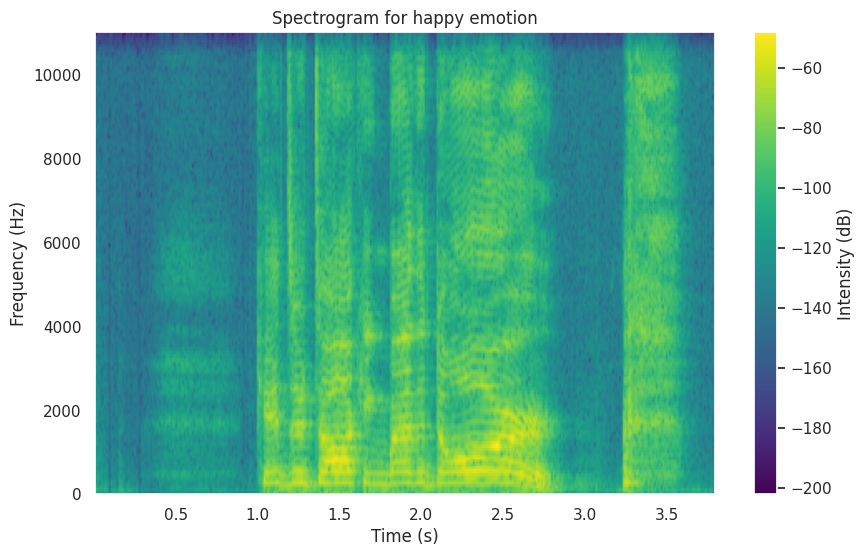

In [19]:
emotion = 'happy'
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]
data, sampling_rate = librosa.load(path)

plt.figure(figsize=(12, 4))
plt.plot(data, color='purple')  # Adjust color
plt.title('Audio Waveform for ' + emotion + ' emotion')  # Add title
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.tight_layout()  # Ensures all elements fit nicely
plt.show()

create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data Augmentation




In [20]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr = sampling_rate, n_steps = pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

#### 1. Simple Audio

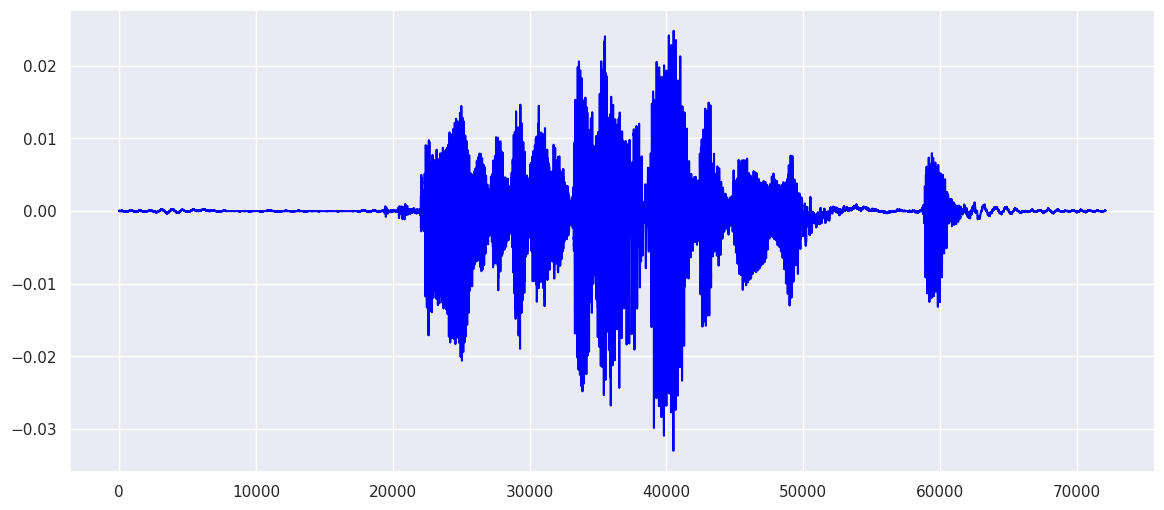

In [21]:
plt.figure(figsize=(14, 6))
plt.plot(data, color='blue', linestyle='-', label='Data')
plt.show()
Audio(path)

#### 2. Noise Injection

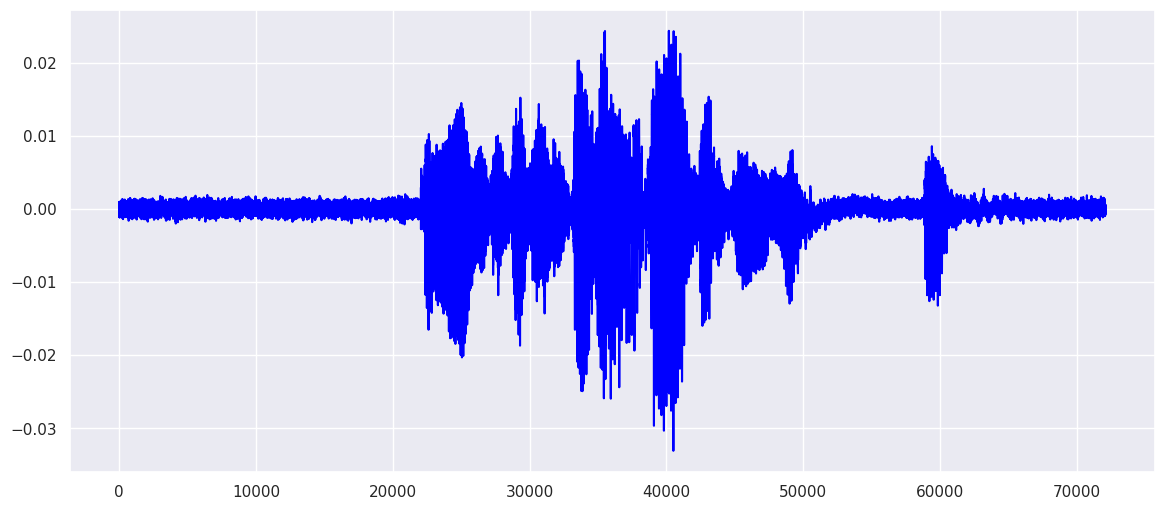

In [22]:
x = noise(data)
plt.figure(figsize=(14, 6))
plt.plot(x, color='blue', linestyle='-', label='Data')
plt.show()
Audio(x, rate=sample_rate)

We can see noise injection is a very good augmentation technique because of which we can assure our training model is not overfitted

#### 3. Stretching

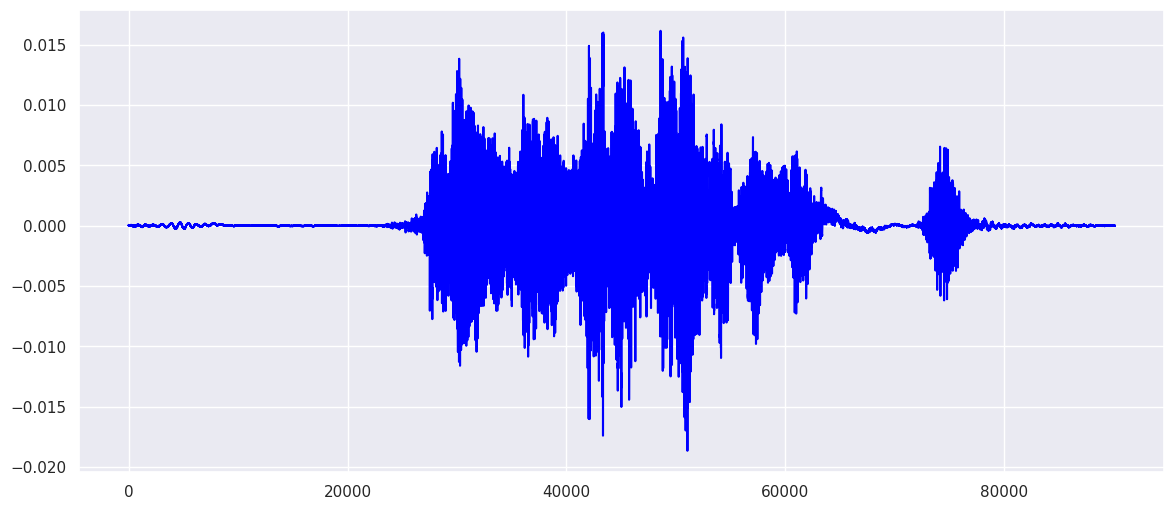

In [23]:
x = stretch(data)
plt.figure(figsize=(14, 6))
plt.plot(x, color='blue', linestyle='-', label='Data')
plt.show()
Audio(x, rate=sample_rate)

#### 4. Shifting

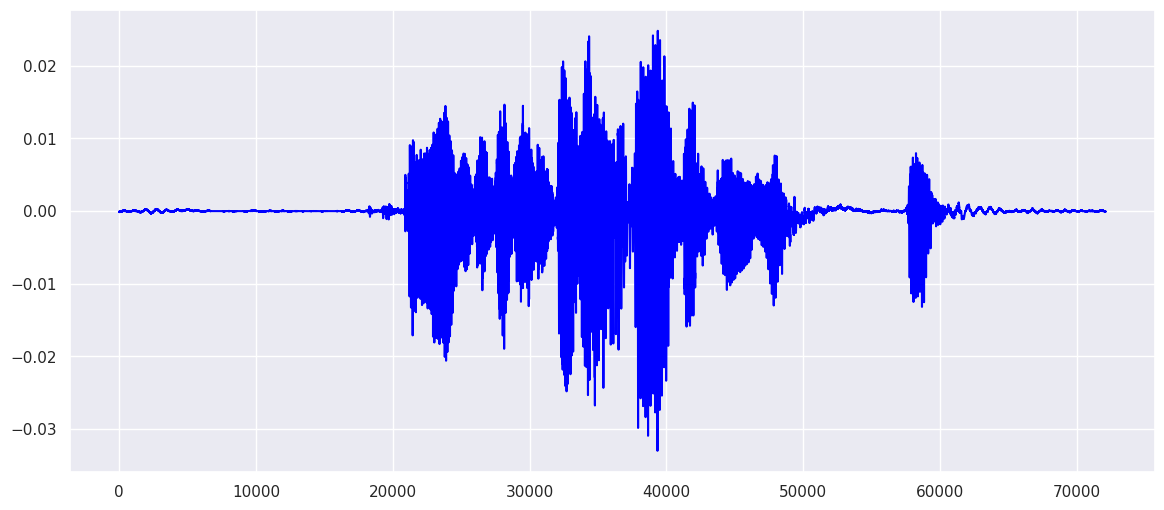

In [24]:
x = shift(data)
plt.figure(figsize=(14, 6))
plt.plot(x, color='blue', linestyle='-', label='Data')
plt.show()
Audio(x, rate=sample_rate)

#### 5. Pitch

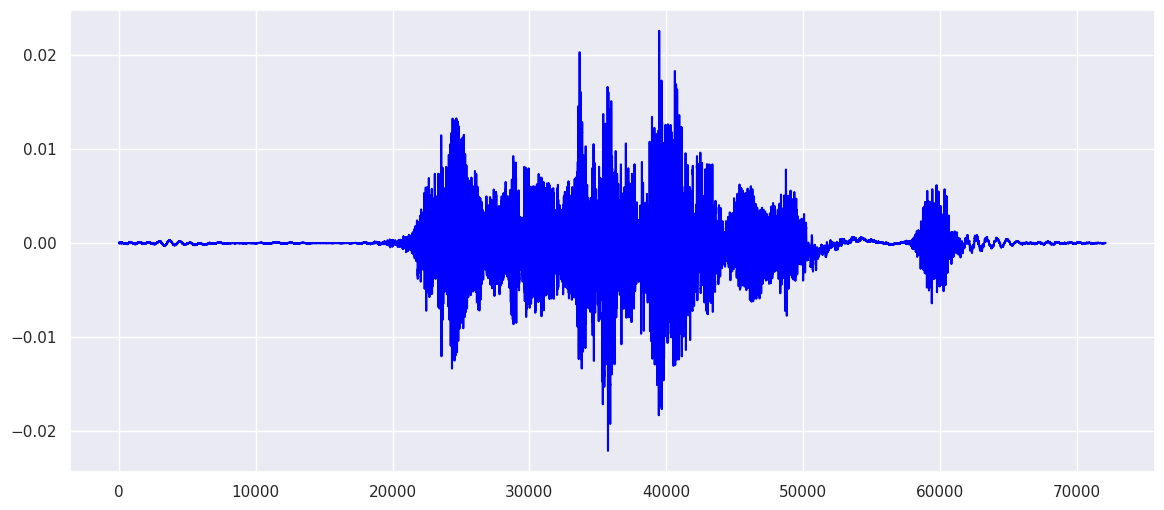

In [25]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14, 6))
plt.plot(x, color='blue', linestyle='-', label='Data')
plt.show()
Audio(x, rate=sample_rate)

- From the above types of augmentation techniques i am using noise, stretching(ie. changing speed) and some pitching.

## Feature Extraction

In [26]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [27]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [28]:
len(X), len(Y), data_path.Path.shape

(36486, 36486, (12162,))

In [29]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.137989  0.563658  0.571770  0.576236  0.559063  0.551714  0.603159   
1  0.120791  0.593526  0.589887  0.592962  0.582871  0.580963  0.608462   
2  0.088643  0.588992  0.553290  0.558148  0.592002  0.575209  0.530399   
3  0.144047  0.648225  0.691701  0.688559  0.683951  0.699161  0.734300   
4  0.178914  0.646958  0.694062  0.707937  0.700674  0.715108  0.746730   

          7         8         9  ...           153       154       155  \
0  0.673473  0.686605  0.580073  ...  6.349041e-06  0.000007  0.000006   
1  0.668963  0.697118  0.607653  ...  6.369071e-06  0.000007  0.000006   
2  0.599675  0.715749  0.725578  ...  9.938746e-07  0.000002  0.000002   
3  0.648453  0.618830  0.636672  ...  7.395461e-06  0.000006  0.000005   
4  0.688193  0.616069  0.640493  ...  8.378353e-06  0.000007  0.000006   

        156           157           158           159           160  \
0  0.000004  3.086954e-06  3.705528e-06  4.856666e-06  2.721255e-06   
1  0.000004  3.100919e-06  3.735176e-06  4.874588e-06  2.745842e-06   
2  0.000002  8.499060e-07  6.419077e-07  6.709389e-07  5.345312e-07   
3  0.000005  6.854427e-06  7.691037e-06  9.460172e-06  5.095632e-06   
4  0.000006  7.841972e-06  8.703079e-06  1.053325e-05  6.038263e-06   

            161  labels  
0  1.900895e-07     sad  
1  1.990889e-07     sad  
2  6.364660e-08     sad  
3  4.648107e-07   happy  
4  1.344118e-06   happy  

[5 rows x 163 columns]

## Data Preparation

- As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [30]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [31]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [32]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [33]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [34]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162, 1), (27364, 8), (9122, 162, 1), (9122, 8))

## Modelling

In [35]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1  (None, 81, 256)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 41, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 21, 128)           0

In [36]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
428/428 [==============================] - 20s 14ms/step - loss: 1.7183 - accuracy: 0.3069 - val_loss: 1.4800 - val_accuracy: 0.4127 - lr: 0.0010
Epoch 2/50
428/428 [==============================] - 5s 11ms/step - loss: 1.4839 - accuracy: 0.4028 - val_loss: 1.3243 - val_accuracy: 0.4644 - lr: 0.0010
Epoch 3/50
428/428 [==============================] - 5s 11ms/step - loss: 1.3840 - accuracy: 0.4432 - val_loss: 1.2809 - val_accuracy: 0.4908 - lr: 0.0010
Epoch 4/50
428/428 [==============================] - 5s 11ms/step - loss: 1.3340 - accuracy: 0.4623 - val_loss: 1.2230 - val_accuracy: 0.5048 - lr: 0.0010
Epoch 5/50
428/428 [==============================] - 5s 11ms/step - loss: 1.2953 - accuracy: 0.4775 - val_loss: 1.2333 - val_accuracy: 0.5050 - lr: 0.0010
Epoch 6/50
428/428 [==============================] - 5s 11ms/step - loss: 1.2582 - accuracy: 0.4944 - val_loss: 1.1833 - val_accuracy: 0.5316 - lr: 0.0010
Epoch 7/50
428/428 [==============================] - 5s 11ms/s

286/286 [==============================] - 2s 5ms/step - loss: 1.1220 - accuracy: 0.6043
Accuracy of our model on test data :  60.425347089767456 %


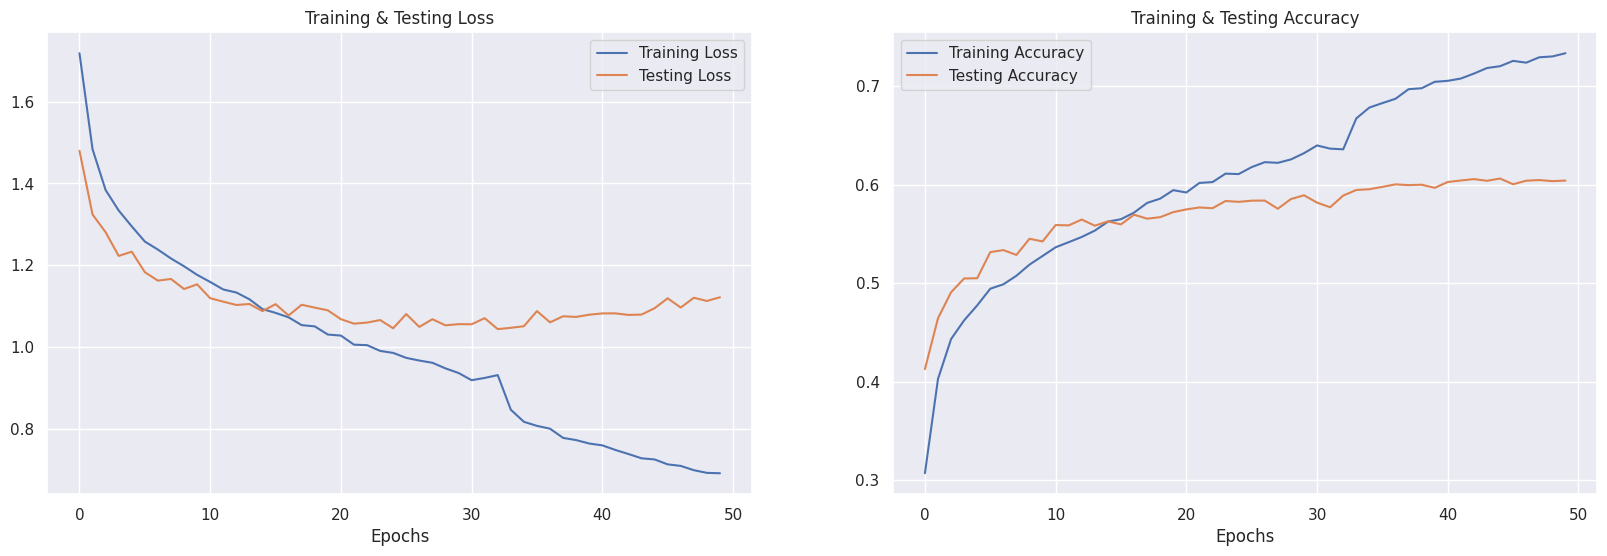

In [37]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [38]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

286/286 [==============================] - 1s 3ms/step


In [39]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0            angry         angry
1            happy         happy
2            happy         happy
3              sad           sad
4          disgust       disgust
5          disgust       disgust
6          disgust       disgust
7          neutral       neutral
8              sad           sad
9          neutral       neutral

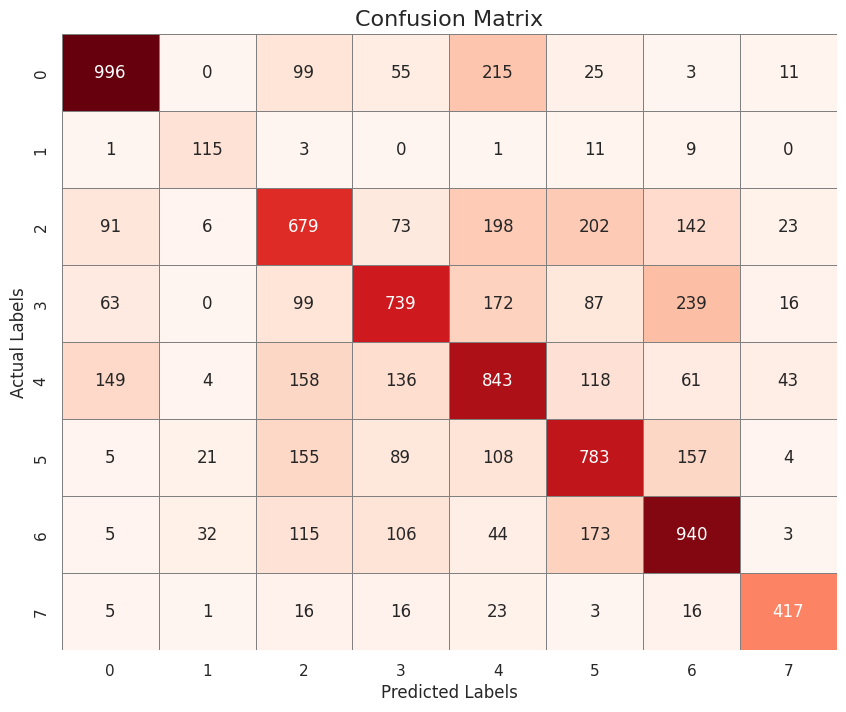

In [45]:
cm = confusion_matrix(y_test, y_pred)

# Assuming you have the confusion matrix stored in the variable 'cm'
plt.figure(figsize=(10, 8))

# Create a heatmap with annotations, using a blue color map ('Blues')
sns.heatmap(cm, annot=True, cmap='Reds', fmt='d', cbar=False,
            annot_kws={"size": 12}, linewidths=0.5, linecolor='gray')

# Set labels and title
plt.title('Confusion Matrix', size=16)
plt.xlabel('Predicted Labels', size=12)
plt.ylabel('Actual Labels', size=12)

# Display the plot
plt.show()

In [41]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.76      0.71      0.73      1404
        calm       0.64      0.82      0.72       140
     disgust       0.51      0.48      0.50      1414
        fear       0.61      0.52      0.56      1415
       happy       0.53      0.56      0.54      1512
     neutral       0.56      0.59      0.57      1322
         sad       0.60      0.66      0.63      1418
    surprise       0.81      0.84      0.82       497

    accuracy                           0.60      9122
   macro avg       0.63      0.65      0.64      9122
weighted avg       0.61      0.60      0.60      9122




- We overall achieved 61% accuracy on our test data and its decent but we can improve it more by applying more augmentation techniques and using other feature extraction methods.